#### Загрузим датасет



In [1]:
!gdown "1IZ2O0R_UqxHSgWNAObPJQeREf320IOgL&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1IZ2O0R_UqxHSgWNAObPJQeREf320IOgL&confirm=t
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:07<00:00, 137MB/s]


In [2]:
!unzip -q seminar_objdet_retina_oi5_ball.zip 

### Вспомогательный код с репоза torchvision

In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 321528, done.
remote: Counting objects: 100% (4550/4550), done.
remote: Compressing objects: 100% (387/387), done.
remote: Total 321528 (delta 4297), reused 4376 (delta 4154), pack-reused 316978
Receiving objects: 100% (321528/321528), 651.56 MiB | 34.94 MiB/s, done.
Resolving deltas: 100% (295649/295649), done.
fatal: not a git repository (or any of the parent directories): .git


### Импорты

In [4]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
import json

### Оформим датасет

Выдает кортеж: изображение и аннотации, то есть боксы, лейбл и т.д.

In [6]:
class DetectionDataset(torch.utils.data.Dataset):

    def __init__(self, data_dict_file, width, height, transforms=None, add_path=None, size=None):
        
        self.height = height
        self.width = width
        self.transforms = transforms

        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            if size is None:
                self.data_dict = {add_path + i:j for i,j in self.data_dict.items()}
            else:
                self.data_dict = {add_path + i:j for i,j in list(self.data_dict.items())[:size]}

        self.imgs = list(self.data_dict.keys())

    def __getitem__(self, idx):

        img_path = self.imgs[idx]

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        h, w = img_res.shape[:2]
        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
        
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(np.ones(len(boxes)), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


Проверим, что все работает

In [7]:

# check dataset
dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                           width=224, height=224, add_path = './seminar_objdet_retina_oi5_ball/')
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[500]
print(img.shape, '\n',target)

length of dataset =  2875 

(224, 224, 3) 
 {'boxes': tensor([[ 23.6029, 115.9070,  68.0850, 165.6558],
        [145.7021,  95.3301, 178.8369, 131.2745]]), 'labels': tensor([1, 1]), 'area': tensor([2212.9346, 1191.0078]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([500])}


### Функция для отрисовки

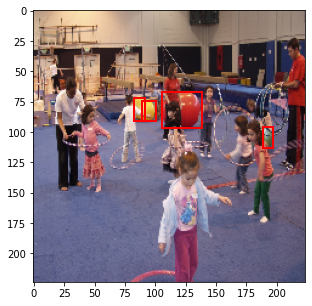

In [8]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()
    
img, target = dataset[50]
plot_img_bbox(img, target)#.permute(1, 2, 0).numpy(), target)

### Модель

Файнтьюнить будем faster-rcnn на resnet50 и fpn. Для этого нужно подгрузить ее предобученную + заменить голову для классификации

In [9]:
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

### Аугментации

В качестве аугментации на трейне будем использовать поворот по горизонтали, зашумление и перевод в серый

In [10]:
def get_transform(train):
    
    if train:
        return A.Compose([A.HorizontalFlip(0.5),
                          A.Blur(),
                          A.ToGray(),
                          ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### Dataset + Dataloader

создадим наши датасеты и соответсвующие им даталоадеры

In [11]:
dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                           width=480, height=480, transforms=get_transform(train=True), add_path = './seminar_objdet_retina_oi5_ball/')
dataset_test = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                           width=480, height=480, transforms=get_transform(train=False), add_path = './seminar_objdet_retina_oi5_ball/')


data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, 
                                          num_workers=4, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False,
                                               num_workers=4,collate_fn=utils.collate_fn)

### Дообучение

Сделаем нашу модель на основе faster-rcnn, предсказывающую 2 класса: бэк и шары\мячи

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_object_detection_model(num_classes)
model.to(device);

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Заморозим все веса, кроме class-head

In [13]:
for p in model.parameters():
  p.requires_grad_(False)

model.roi_heads.box_predictor.requires_grad_(True)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

Запустим обучение на 3 эпохи

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4,)                
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/719]  eta: 1:34:04  lr: 0.000001  loss: 1.1086 (1.1086)  loss_classifier: 0.7180 (0.7180)  loss_box_reg: 0.3414 (0.3414)  loss_objectness: 0.0365 (0.0365)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 7.8504  data: 0.5566  max mem: 1178
Epoch: [0]  [100/719]  eta: 0:04:12  lr: 0.000042  loss: 0.5297 (0.8601)  loss_classifier: 0.3569 (0.5118)  loss_box_reg: 0.1151 (0.1666)  loss_objectness: 0.0518 (0.1594)  loss_rpn_box_reg: 0.0061 (0.0223)  time: 0.3336  data: 0.0156  max mem: 1178
Epoch: [0]  [200/719]  eta: 0:03:14  lr: 0.000084  loss: 0.3372 (0.6778)  loss_classifier: 0.1653 (0.3702)  loss_box_reg: 0.0905 (0.1477)  loss_objectness: 0.0421 (0.1397)  loss_rpn_box_reg: 0.0039 (0.0202)  time: 0.3446  data: 0.0169  max mem: 1178
Epoch: [0]  [300/719]  eta: 0:02:33  lr: 0.000126  loss: 0.3490 (0.5953)  loss_classifier: 0.1306 (0.2974)  loss_box_reg: 0.0840 (0.1330)  loss_objectness: 0.0545 (0.1448)  loss_rpn_box_reg: 0.0055 (0.0201)  time: 0.3493  data: 0.0166  max mem: 1178


Посчитаем mAP по последней эпохе, усреднив значения AP

In [15]:
aps = np.array([0.391, 0.615, 0.426, 0.292, 0.501, 0.544])
print(f"mAP = {aps.mean()}")

mAP = 0.4615


Результаты не самые высокие, но и не такие уж и плохие. Главное, что хочется проверить, так это разморозить все веса и попробовать еще пообучать. Только у меня gpu'ха в колабе наелась, отпраивли в бан... Не успеваю до дедлоса((

### Отрисуем результаты

(array([0, 1]),)


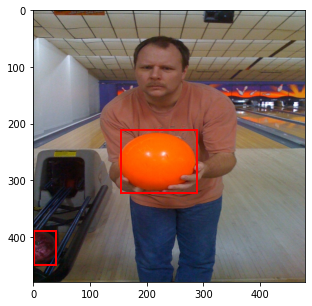

(array([0, 1]),)


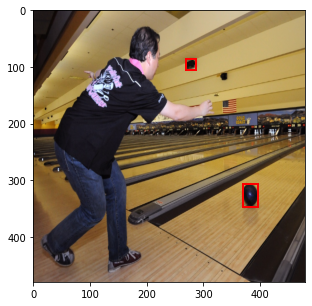

(array([0, 1, 2, 3, 4, 5, 6, 7]),)


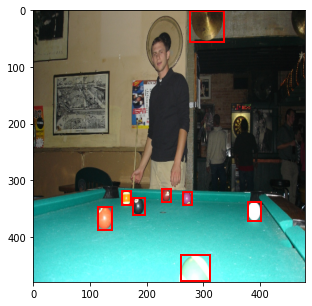

(array([0]),)


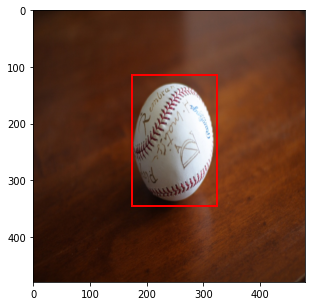

(array([0, 1, 2, 3, 4]),)


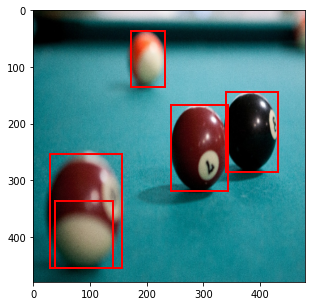

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)


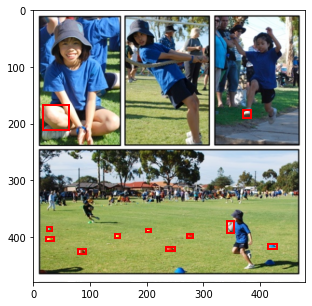

(array([0, 1, 2, 3, 4]),)


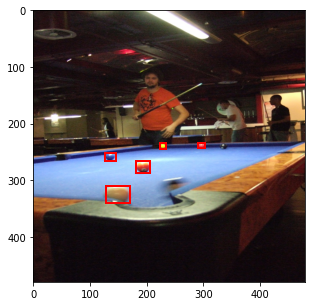

(array([0, 1]),)


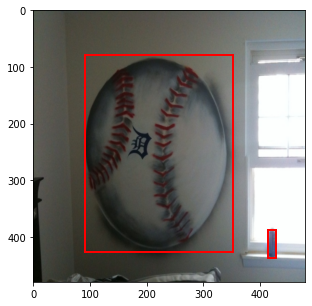

(array([0, 1, 2]),)


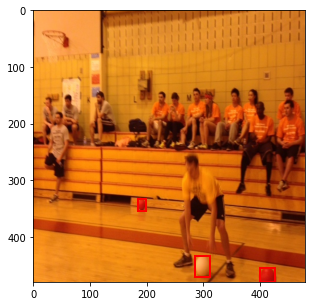

(array([0, 1]),)


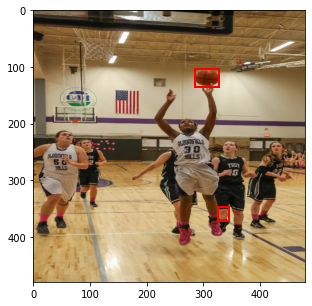

In [16]:
model.eval()
for i in range(10):
    index = np.random.randint(len(dataset_test))
    tensor = dataset_test[index][0].unsqueeze(0)
    #run_and_show(model, tensor, 0.5, {1: "ball"})
    with torch.no_grad():
        out = model(tensor.to(device))[0]
        idxs = np.where(out['scores'].cpu().numpy() > 0.5)
        print(idxs)
        boxes = {'boxes': out['boxes'][idxs].cpu().numpy()}
    plot_img_bbox(tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), boxes)

Довольно хорошо справляется, умеет находить много маленьких шаров, хоть местами и ошибается